In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import thunder as td
from os.path import sep
from fish.util.fileio import load_image
from fish.image.vol import filter_flat, unfilter_flat, dff
from fish.util.plot import proj_fuse
from skimage.exposure import rescale_intensity as rescale
from skimage.transform import downscale_local_mean
from glymur import jp2k
%matplotlib inline

In [ ]:
def guess_experimenter(fname):
        if fname.find('Yu') > 0:
            return 'yu'
        elif fname.find('davis') > 0:
            return 'davis'
        else:
            return ''
        
def tidy_up_mask(im):
    from skimage.morphology import disk, binary_opening, remove_small_objects, remove_small_holes
    im_ = im.copy()
    im_ = binary_opening(im_, disk(3))
    im_ = remove_small_objects(im_, min_size=500)
    im_ = remove_small_holes(im_, min_size=5000)
    return im_

In [ ]:
base_dirs = ('/groups/ahrens/ahrenslab/davis/data/spim/raw/20160607/5dpf_cy171xcy221_f1_omr_1_20160607_183009/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171004/7dpf_cy171xec43_f1_omr_opto_1_20171004_113405/',            
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171008/7dpf_cy171xec43_f1_opto_1_20171008_153145/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171008/7dpf_cy171xec43_f2_opto_1_20171008_173349/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171023/5dpf_cy171xec43_f1_h33342_cntrl_omr_opto_1_20171023_220741/',
             '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171107/6dpf_cy171xec43_f1_opto_1_20171107_195521/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171107/6dpf_cy171xec43_f2_opto_1_20171107_220215/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171108/7dpf_cy171xec43_f1_opto_2_12mw_20171108_215904/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171108/7dpf_cy171xec43_f1_opto_1_20171108_213653/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171108/7dpf_cy171xec43_f2_opto_1_20171108_232927/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171108/7dpf_cy171xec43_f2_opto_2_12mw_20171108_235105/',
            '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170203/fish1/20170203_1_4_gfapgcamp_hucrgeco_8dpf_wholebrain_CL_0gain_modulation_20170203_122038/',
            '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/',
            '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
            '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/')

# do different things to the directories depending on whether data are davis' or yu's
paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]
experimenter = guess_experimenter(paths['base'])

bidirectional_stack=False

if experimenter is 'yu':
    print('These data are from Yu.')
    paths['raw'] = paths['base'] + 'raw/'
    # need to deal with permissions for some data, so results will be in a temporary folder
    paths['reg'] = '/groups/ahrens/ahrenslab/davis/tmp/' + paths['base'].split(sep)[-2] + sep
    paths['proj'] =  paths['reg'] + 'projections' + sep
    # paths['proj'] = paths['base'] + 'projections/'
        

elif experimenter is 'davis':
    print('These data are from Davis')    
    paths['raw'] = paths['base']
    paths['proc'] = paths['raw'].replace('raw', 'proc')
    paths['proj'] = paths['proc'] + 'proj/'
    paths['reg'] = paths['proc'] + 'reg/'

# Get the camera background image
background_im_fname = paths['raw'] + 'Background_0.tif'
background_im = jp2k.Jp2k(background_im_fname)[:]

fnames = glob(paths['raw'] + 'TM*')
fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

from fish.image.vol import get_stack_freq
fs_im = 1 / get_stack_freq(paths['raw'])[0]    
print('Sampling rate:  {0} Hz'.format(1 / fs_im))

# set correct aspect ratio for plotting
from fish.image.vol import get_metadata
exp_data = get_metadata(paths['raw'] + 'ch0.xml')
bidirectional_stack = exp_data['bidirectional_stack'] == 'T'
z_step = exp_data['z_step']
aspect = (int(z_step / .406), 1, 1)

from os.path import exists
if not exists(paths['proj']):
    from os import makedirs
    makedirs(paths['proj'])
else:
    print('Num existing projections: {0}'.format(len(glob(paths['proj'] + 't*'))))
print('Bidirectional stack : {0}'.format(bidirectional_stack))

In [4]:
plr = slice(0, None)
ims = td.images.fromlist(fnames[plr], accessor=load_image, engine=sc, npartitions=len(fnames[plr])).median_filter(size=(1,3,3)).astype('float32')
if bidirectional_stack:
    from fish.image.vol import rearrange_bidirectional_stack
    ims = ims.map(rearrange_bidirectional_stack)

In [6]:
%%time
do_registration = True

if not exists(paths['reg'] + 'anat_reference.tif'):
    ref_range = (len(fnames) // 2) + np.arange(-5,5)
    ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=load_image)
    ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('uint16')

    if bidirectional_stack:
        ref = rearrange_bidirectional_stack(ref)

    # save reference image to disk 
    from skimage.io import imsave

    #makedirs(paths['reg'])
    imsave(paths['reg'] + 'anat_reference.tif', ref, compress=1)
else:
    from skimage.io import imread
    ref = imread(paths['reg'] + 'anat_reference.tif').astype('float32')

try:
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
    affs = affs[plr]
    print('Registration params found')
except(FileNotFoundError):
    print('Registration params not found, performing registration')
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/davis/tmp/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/anat_reference.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Registration params not found, performing registration
CPU times: user 3min 12s, sys: 4.87 s, total: 3min 17s
Wall time: 45min 53s


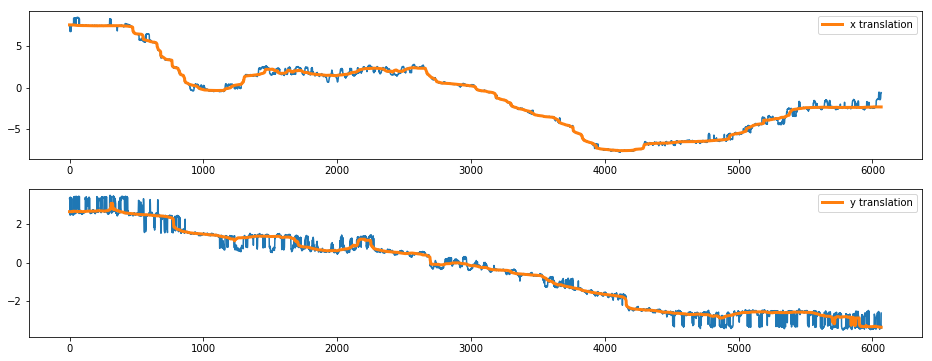

In [7]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

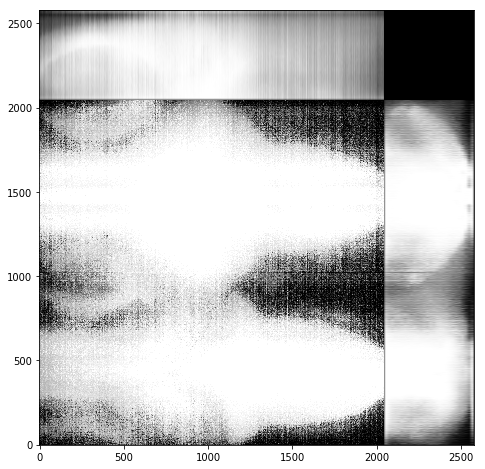

In [8]:
fig, axs = plt.subplots(figsize=(8,8))
fill_val = np.median(background_im)
mask = ref > fill_val
axs.imshow(proj_fuse(mask, np.mean, aspect=aspect), origin='lower', cmap='gray');

In [9]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=fill_val), with_keys=True).astype('float32')

In [10]:
# generate local projections 
def my_proj(v, slab_size = 4, axis=0):    
    from fish.image.vol import sub_proj    
    from numpy import amax
    # number of planes per projection        
    n_slabs = int(np.ceil(v.shape[axis] / slab_size))    
    chopped = sub_proj(v, axis, amax, n_slabs)
    return chopped

# save the images
def save_ims(kv, dest_dir):
    from skimage.io import imsave
    key = kv[0][0]
    val = kv[1]    
    fname = 't_{:06d}.tif'.format(key)
    imsave(dest_dir + fname, val, compress=1)

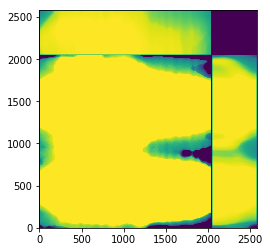

In [11]:
from scipy.ndimage.filters import gaussian_filter
mask = gaussian_filter(ref.astype('float32'), sigma=[5,20,20]) > fill_val * 1

y_lim = 1 + np.abs(np.array([min(trans[1,:]), max(trans[1,:])])).astype('int')
x_lim = 1 + np.abs(np.array([min(trans[2,:]), max(trans[2,:])])).astype('int')

if x_lim[0] > 0:
    mask[:,:,:x_lim[0]] = False
if x_lim[1] > 0:
    mask[:,:,-x_lim[1]:] = False
if y_lim[0] > 0:
    mask[:,:y_lim[0],:] = False
if y_lim[1]  > 0:
    mask[:,-y_lim[1]:,:] = False

plt.imshow(proj_fuse(mask, np.mean, aspect=aspect), origin='lower');

In [12]:
%%time
# take 300s baseline
baseline_window = int(300 / fs_im)
baseline_offset = 10
mydff = lambda v: dff(v, baseline_window, percentile=20, baseline_offset=baseline_offset)
ds = 2
mask_ds = mask[:,::ds,::ds]

# subtract camera background, clip off negative values
ims_reg_bs = ims_registered.map(lambda v: np.clip(v - fill_val, a_min=1, a_max=None))

# smoothing then downsampling
ims_ds = ims_reg_bs.map(lambda v: downscale_local_mean(v, (1,ds,ds)))

# apply mask
ims_reg_masked = ims_ds.map(lambda v: v * mask_ds)

#take dff only of masked pixels by flattening masked images
mask_ds_bc = sc.broadcast(mask_ds)
ims_flat = ims_ds.map(lambda v: filter_flat(v, mask_ds_bc.value))
ims_dff = ims_flat.map_as_series(mydff, value_size=len(fnames[plr]), dtype='float64').map(lambda v: unfilter_flat(v, mask_ds_bc.value))

# get min and max
bounds = ims_dff.map(lambda v: np.array([v.min(), v.max()])).toarray()

CPU times: user 19.4 s, sys: 2.14 s, total: 21.5 s
Wall time: 1h 28min 53s


## Apply dff-based mask and rescale

In [13]:
out_range = 'uint16'
mn, mx = bounds.min(), bounds.max()

# assuming 2-color imaging here, so we have 1 y-projection for each color
y_slab_size = ims_dff.shape[2] // 2
slabs_z = ims_dff.map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: my_proj(v, axis=0)).astype('uint16')
slabs_y = ims_dff.map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: my_proj(v, axis=1, slab_size=y_slab_size)).astype('uint16')

## Save projections

In [23]:
%%time
from os.path import exists
tmp_paths = {}
tmp_paths['y'] = paths['proj'] + 'y/'
tmp_paths['z'] = paths['proj'] + 'z/'

from os import makedirs
if not exists(tmp_paths['z']):
    makedirs(tmp_paths['z'])
    
if not exists(tmp_paths['y']):
    makedirs(tmp_paths['y'])

slabs_z.tordd().foreach(lambda v: save_ims(v, tmp_paths['z']))
slabs_y.tordd().foreach(lambda v: save_ims(v, tmp_paths['y']))

CPU times: user 1.06 s, sys: 262 ms, total: 1.32 s
Wall time: 1min 49s


## Save metadata

In [15]:
print(mn)
print(mx)

-0.664444088936
57.7459716797


In [16]:
metadata = {}
metadata['raw_data_path'] = paths['raw']
metadata['dff_lims'] = [float(mn), float(mx)]
metadata['spatial_downsampling'] = ds
metadata['dff_window'] = baseline_window

In [17]:
import json
metadata_fname = tmp_paths['y'] + 'metadata.json'
with open(metadata_fname, 'w') as fp:
    json.dump(metadata, fp)
    
metadata_fname = tmp_paths['z'] + 'metadata.json'
with open(metadata_fname, 'w') as fp:
    json.dump(metadata, fp)